<a href="https://colab.research.google.com/github/KarlaLutz/Trabalho_CNN_Turma9_BigData_FGV/blob/main/Trabalho_CNN_XRays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalando Bibliotecas e Preparando o Ambiente do Dataset**

In [ ]:
# Para a execução do ExplanabeAI posteriormente

%tensorflow_version 1.x

In [18]:
pip install shap

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [19]:
pip list | grep tensorflow

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from glob import glob
import numpy as np
import pandas as pd
import pickle

In [21]:
# Motando google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
# Professor, nesse step, antes de rodar o código, favor acessar o seguinte drive: https://drive.google.com/drive/folders/1XcG4umqBU37TE1E5bQHuW1zVCKM2GXaB?usp=sharing
  # E criar um atalho da pasta Xrays para o seu drive (Add Shortcut To Drive), dessa forma terá acesso às imagens que utilizamos.

# Nesta etapa estamos categorizando as imagens em imagens de pulmões com Pneumonia e Normal.
# Criamos um loop para rodar no nosso database de imagens de Raio-X e baseado no label de cada imagem, categorizamos como tal.

labels = ['PNEUMONIA','NORMAL']
img_size = 150
def recupera_dados_drive(data_dir):
    data = [] 
    for label in labels: 
      for path in glob(os.path.join(data_dir, label+'*')): 
        class_num = labels.index(label)
        for img in os.listdir(path):            
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# Professor nesta etapa deixamos a sua escolha rodar a criação dos datasets conforme abaixo (para nós demorou mais do que 30mins)
# ou utilizar os arquivos pickles que salvamos quando rodamos a primeira vez, conforme células dos códigos abaixo.

# Separando o Dataset já categorizado nas bases de treino, teste e validação;
# Com a base de treino, iremos pegar cerca de 70% das imagens onde utilizaremos para ensinar nosso modelo;
# Com a base de validação nós iremos realizar um tipo de doublecheck naquilo que nosso modelo foi capaz de aprender da etapa anterior;
# Finalmente, com a base de teste, iremos testar se o modelo está acertando ou errando.

train = recupera_dados_drive('/content/drive/MyDrive/Xrays/Training/')
test = recupera_dados_drive('/content/drive/MyDrive/Xrays/Test/')
val = recupera_dados_drive('/content/drive/MyDrive/Xrays/Validation/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [23]:
# Arquivos pickle dos datasets

os.chdir("/content/drive/My Drive/Xrays")

pickle_in = open("train.pickle","rb")
train = pickle.load(pickle_in)

pickle_in = open("test.pickle","rb")
test = pickle.load(pickle_in)

pickle_in = open("val.pickle","rb")
val = pickle.load(pickle_in)


# **Visualização e Limpeza dos Dados**

Text(0.5, 1.0, 'NORMAL')

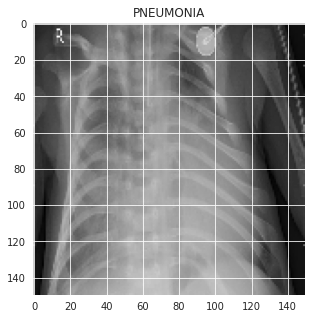

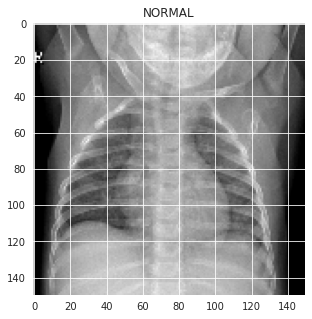

In [24]:
# Vamos plotar uma imagem de exemplo de cada categoria apenas para uma verificação simples.

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [25]:
# Separando as features da variável resposta dos datasets de treino, validação e teste

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [26]:
# Neste ponto iremos normalizar os dados. Como a escala de cores chega até o número 255, vamos simplificar isso alterando para 0s e 1s, assim nosso modelo conseguirá ler os dados propriamente

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [27]:
# Vamos agora remodelar nossas matrizes dos três datasets para um vetor de forma que nossos dados não sejam alterados
# Como a dimensão dessa matriz é desconhecida, passaremos o parâmetro -1 para que o numpy descubra observando o comprimento da matriz e suas dimensões restantes
# Dessa forma se certificando de que atende aos critérios mencionados acima

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# **Primeiro Modelo**

In [28]:
# Neste primeiro modelo, rodaremos com os dados crus do dataset, sem nenhum tipo de incremento para observar o desempenho

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_poolin

In [29]:
# Ensinado ao modelo

history = model.fit(x_train,y_train, batch_size = 32 ,epochs = 12 , validation_data = (x_val, y_val))


Train on 5030 samples, validate on 30 samples
Epoch 1/12
5030/5030 [==============================] - 191s 38ms/step - loss: 0.3696 - accuracy: 0.8451 - val_loss: 0.0603 - val_accuracy: 1.0000
Epoch 2/12
5030/5030 [==============================] - 192s 38ms/step - loss: 0.1691 - accuracy: 0.9501 - val_loss: 0.0856 - val_accuracy: 0.9667
Epoch 3/12
5030/5030 [==============================] - 192s 38ms/step - loss: 0.1024 - accuracy: 0.9644 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 4/12
5030/5030 [==============================] - 192s 38ms/step - loss: 0.0835 - accuracy: 0.9662 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 5/12
5030/5030 [==============================] - 193s 38ms/step - loss: 0.0667 - accuracy: 0.9763 - val_loss: 0.0557 - val_accuracy: 1.0000
Epoch 6/12
5030/5030 [==============================] - 192s 38ms/step - loss: 0.0555 - accuracy: 0.9787 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 7/12
5030/5030 [==============================] - 192s 38ms/step 

In [30]:
print("A perca obtida com o modelo treinado é de" , model.evaluate(x_test,y_test)[0])
print("A acurácia do nosso modelo é de" , model.evaluate(x_test,y_test)[1]*100 , "%")

166/166 [==============================] - 2s 10ms/step
A perca obtida com o modelo treinado é de 0.0669941010741876
166/166 [==============================] - 2s 10ms/step
A acurácia do nosso modelo é de 98.79518151283264 %


# **Analise Gráfica Pós Treinamento - Primeiro Modelo**

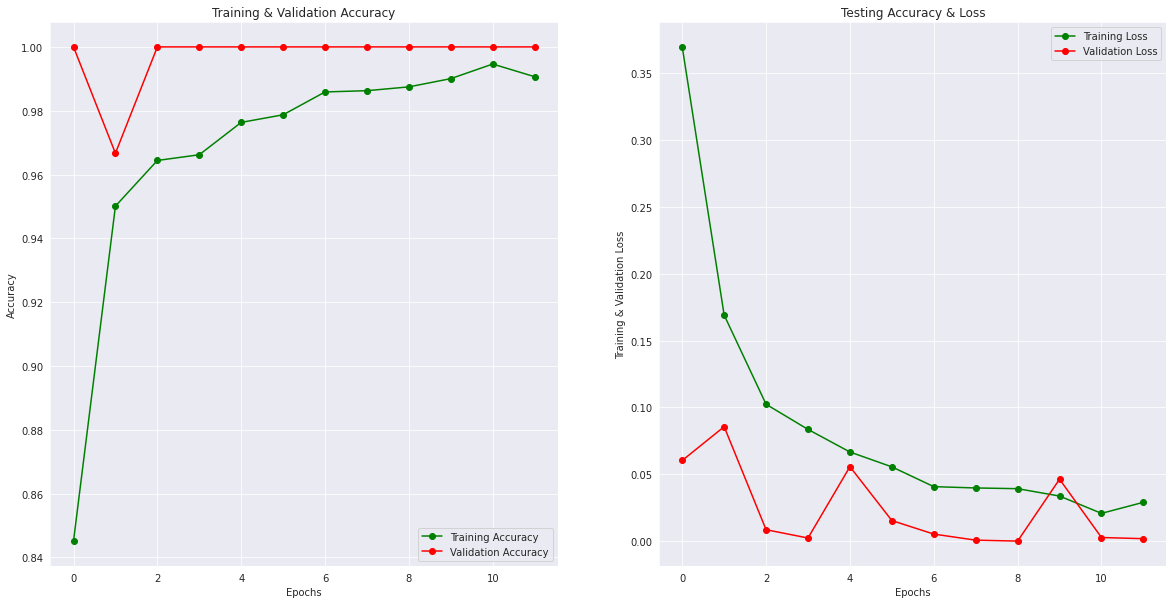

In [32]:
# Observando os plots dos resultados gerados pelo nosso primeiro modelo, podemos entender que possívelmente temos um modelo que apresenta overfitting
# Ou seja temos um modelo que faz as analises serem muito exatas ao nosso dataset original, e que devido a isso pode falahr quando tentarmos realizar o fit de dados adicionais ao dataset
# Tanmbém poderemos ter muitas falhas no momento de prever com novas imagens.

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [33]:
# Agora que temos nosso modelo treinado, realizaremos predições de algumas imagens
# O retorno da predição é um array de 10 números. Eles representam um a confiança do modelo que a imagem corresponde a cada um dos raios-X. 
# Podemos ver cada label tem um maior valor de confiança.
# No caso do nosso resultado, temos que nosso modelo conseguirá realmente acertar apenas 50% das imagens, uma vez que o resultado do array foi zerado para todas as linhas.

predictions = model.predict(x_test)
predictions = np.round(predictions).astype(int)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
# Abaixo temos o print do valor de precisão, recall, f1-scores e support para cada uma das categorias.
# A precisão fala sobre quão exato é nosso modelo em relação aos positivos previstos, quantos deles são realmente positivos.
# O recall calcula quantos dos positivos reais nosso modelo captura, que foram rotulados como positivo (verdadeiro positivo)
# O F1-score é uma função da precisão e do recall. Ele representa o balanceamento entre a precisão e o recall, como podemos ter uma distribuição de classes desigual, utilizar essa métrica pode ser viável.
# Suporte é o número de ocorrências reais da classe no conjunto de dados especificado. O suporte desequilibrado nos dados de treinamento pode indicar fraquezas estruturais nas pontuações relatadas do classificador e pode indicar a necessidade de amostragem estratificada ou rebalanceamento.

# Podemos ver que com o resultado das métricas, temos com certeza um modelo que apresenta overfitting.

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.99      0.99        84
   Normal (Class 1)       0.99      0.99      0.99        82

           accuracy                           0.99       166
          macro avg       0.99      0.99      0.99       166
       weighted avg       0.99      0.99      0.99       166



In [36]:
# Matriz de Confusão

# Pela matriz de confusão do resultado do nosso modelo, podemos ver que nosso modelo está acertando praticamente todas as imagens do dataset.
# Isso novamente nos indica um overfitting, o que pode ser muito ruim quando tentarmos prever novas imagens incrementais no dataset.

cm = confusion_matrix(y_test,predictions)
cm

array([[83,  1],
       [ 1, 81]])

In [37]:
# Separando o que identificamos como correto e incorreto

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

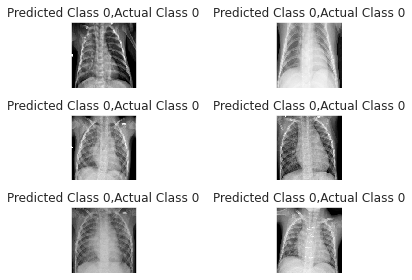

In [38]:
# Alguns exemplos de classificações corretas

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

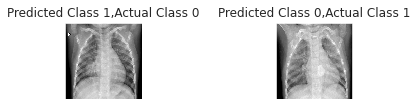

In [39]:
# Alguns exemplos de classificação incorreta

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# **Data Augmentation**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


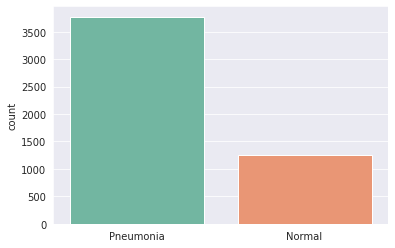

In [40]:
# Vamos analisar como está a distribuição dos nossos dados em relação as categorizações feitas no dataset de treino.
# Podemos notar que temos muito mais imagens de Raios-X com Pneumonia do que Normais, por isso utilizaremos da técnica de Data Augmentation para nivelar essa diferença.

imagens = []
for i in train:
    if(i[1] == 0):
        imagens.append("Pneumonia")
    else:
        imagens.append("Normal")
sns.set_style('darkgrid')
sns.countplot(imagens, palette = "Set2")   

In [41]:
# Como pudemos observar anteriormente temos um desbalanceamento no dataset de treino.
# Para nivelar essa diferença utilizaremos de métodos como rotação, zoom, alterações verticais/horizontais e espelhamento para criar novas imagens a partir daquelas já existentes.

datagen = ImageDataGenerator(
  rotation_range = 0.1,  # Rotacionando a imagem em 1 grau
  width_shift_range = 0.11,  # Alterando a imagem na horizontal em 11%
  height_shift_range = 0.12,  # Alterando a imagem na vertical em 12%
  horizontal_flip = True,  # Espelhando na horizontal
  vertical_flip = True,  # Espelhando na vertical
  zoom_range = 0.2) # Aplicando um zoom de 2%  

datagen.fit(x_train)

# **Segundo Modelo - Com Data Augmentation**

In [57]:
# Iniciaremos o treino do nosso modelo utilizando XX neuronios.
# Aplicaresmos um padrão na forma das imagens de 150 x 150, a função de ativação dos neuronios intermediários será relu e a do último aplicaremos o sigmoid.

model2 = Sequential()
model2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.1))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model2.add(Flatten())
model2.add(Dense(units = 128 , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1 , activation = 'sigmoid'))
model2.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 19, 19, 64)       

In [58]:
# Ensinando ao modelo

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [59]:
# Validaremos o treino realizado acima no nosso dataset de validação para dar um doublecheck 

history2 = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
158/158 [==============================] - 220s 1s/step - loss: 0.5348 - accuracy: 0.7515 - val_loss: 0.6343 - val_accuracy: 0.6667
Epoch 2/12
158/158 [==============================] - 219s 1s/step - loss: 0.3987 - accuracy: 0.8153 - val_loss: 0.5244 - val_accuracy: 0.7333
Epoch 3/12
158/158 [==============================] - 219s 1s/step - loss: 0.3171 - accuracy: 0.8656 - val_loss: 0.2275 - val_accuracy: 0.9000
Epoch 4/12
158/158 [==============================] - 219s 1s/step - loss: 0.2699 - accuracy: 0.8909 - val_loss: 0.2624 - val_accuracy: 0.8667
Epoch 5/12
158/158 [==============================] - 218s 1s/step - loss: 0.2627 - accuracy: 0.8950 - val_loss: 0.2091 - val_accuracy: 0.9667
Epoch 6/12
158/158 [==============================] - 217s 1s/step - loss: 0.2471 - accuracy: 0.9062 - val_loss: 0.2748 - val_accuracy: 0.9000
Epoch 7/12
158/158 [==============================] - 216s 1s/step - loss: 0.2251 - accuracy: 0.9099 - val_loss: 0.2216 - val_accuracy: 0.9333

In [60]:
print("A perca obtida com o modelo treinado é de" , model2.evaluate(x_test,y_test)[0])
print("A acurácia do nosso modelo é de" , model2.evaluate(x_test,y_test)[1]*100 , "%")

166/166 [==============================] - 2s 10ms/step
A perca obtida com o modelo treinado é de 0.1846425258610622
166/166 [==============================] - 2s 10ms/step
A acurácia do nosso modelo é de 95.783132314682 %


# **Analise Gráfica Pós Treinamento - Segundo Modelo Com Data Augmentation**

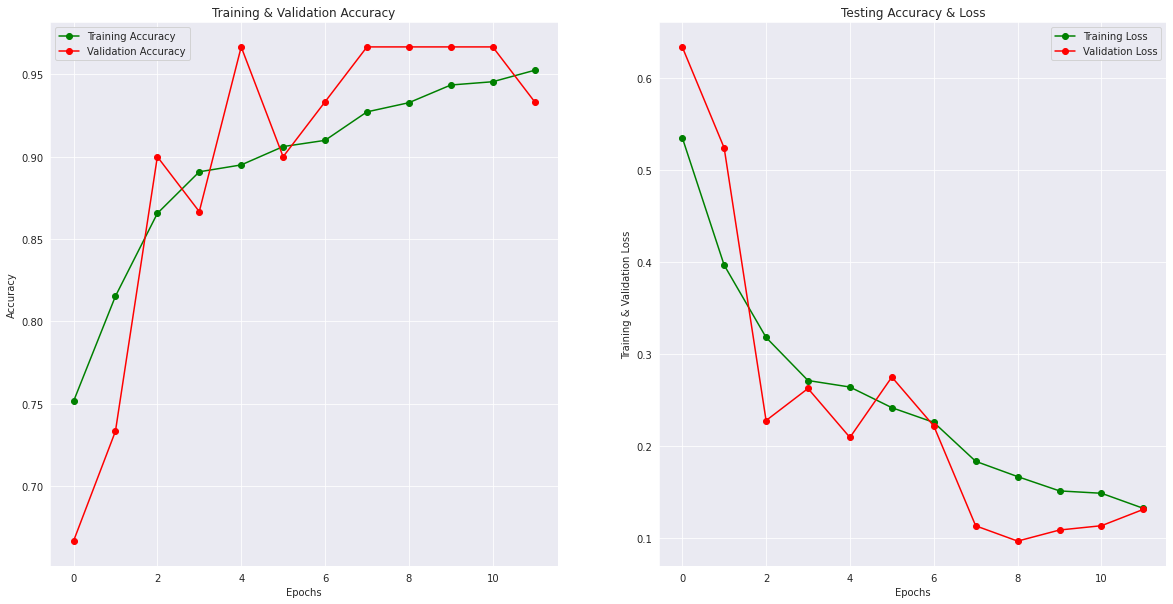

In [61]:
# Na versão do modelo contendo data augmentation, conseguimos ver uma melhora na nossa curva de aprendizado.
# Conseguimos ver que por mais que erros ocorram, o modelo tende a seguir uma constancia boa de acertos e por mais que novas imagens entrem no dataset, ele será capaz de compreende-las.

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc2 = history2.history['accuracy']
train_loss2 = history2.history['loss']
val_acc2 = history2.history['val_accuracy']
val_loss2 = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc2 , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc2 , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss2 , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss2 , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [62]:
# Podemos ver uma variação no nosso array de predições, o que indica que nosso modelo 2 tem uma porcentagem melhor de acertos.

predictions2 = model2.predict(x_test)
predictions2 = np.round(predictions2).astype(int)
predictions2 = predictions2.reshape(1,-1)[0]
predictions2[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
# Nossas métricas de análise do modelo estão ótimas, temos uma precisão e recall que avaliam os verdadeiros positivos acima de 90%, porém não overfittando como no modelo 1.


print(classification_report(y_test, predictions2, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.98      0.94      0.96        84
   Normal (Class 1)       0.94      0.98      0.96        82

           accuracy                           0.96       166
          macro avg       0.96      0.96      0.96       166
       weighted avg       0.96      0.96      0.96       166



In [64]:
# Matriz de Confusão

# Nossa matriz de confusão também apresenta valores muito mais reais, e um dos pontos mais importantes é que temos um número bem baixo de falsos negativos.
# No nosso projeto é importante não termos muitos falsos negativos pois isso indicaria pulmões com pneumonia que foram classificados como normais.

cm2 = confusion_matrix(y_test,predictions2)
cm2

array([[79,  5],
       [ 2, 80]])

# **Classificação Categorica**



> **Preparação do Dataset**



In [ ]:
categories = ['PNEUMONIA_BACTERIA','PNEUMONIA_VIRAL','NORMAL']
img_size = 150
def recupera_dados_cat_drive(data_dir):
    data = [] 
    for category in categories: 
      for path in glob(os.path.join(data_dir, category)): 
        class_num = categories.index(category)
        for img in os.listdir(path):            
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# Para rodar os datasets do zero

train_cat = recupera_dados_cat_drive('/content/drive/MyDrive/Xrays/Training/')
test_cat = recupera_dados_cat_drive('/content/drive/MyDrive/Xrays/Test/')
val_cat = recupera_dados_cat_drive('/content/drive/MyDrive/Xrays/Validation/')

In [ ]:
# Para puxar os arquivos pickles dos datasets já baixados

os.chdir("/content/drive/My Drive/Xrays")

pickle_in = open("train_cat.pickle","rb")
train_cat = pickle.load(pickle_in)

pickle_in = open("test_cat.pickle","rb")
test_cat = pickle.load(pickle_in)

pickle_in = open("val_cat.pickle","rb")
val_cat = pickle.load(pickle_in)



> **Verificação dos Dados e Pré-processamento**



In [ ]:
# Verificando a distribuição dos dados

l = []
for i in train_cat:
    if(i[1] == 0):
        l.append("Bacteria")
    if(i[1] == 1):
        l.append("Viral")
    if(i[1] == 2):
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

In [ ]:
# Separando a variável respostas das features em cada dataset

x_train_cat = []
y_train_cat = []

x_val_cat = []
y_val_cat = []

x_test_cat = []
y_test_cat = []

for feature, label in train_cat:
    x_train_cat.append(feature)
    y_train_cat.append(label)

for feature, label in test_cat:
    x_test_cat.append(feature)
    y_test_cat.append(label)
    
for feature, label in val_cat:
    x_val_cat.append(feature)
    y_val_cat.append(label)

In [ ]:
x_train_cat = np.array(x_train_cat) / 255
x_val_cat = np.array(x_val_cat) / 255
x_test_cat = np.array(x_test_cat) / 255

In [ ]:
x_train_cat = x_train_cat.reshape(-1, img_size, img_size, 1)
y_train_cat = np.array(y_train_cat)

x_val_cat = x_val_cat.reshape(-1, img_size, img_size, 1)
y_val_cat = np.array(y_val_cat)

x_test_cat = x_test_cat.reshape(-1, img_size, img_size, 1)
y_test_cat = np.array(y_test_cat)



> **Primeiro Modelo**



In [ ]:
modelc1 = Sequential()
modelc1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
modelc1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc1.add(Flatten())
modelc1.add(Dense(units = 128 , activation = 'relu'))
modelc1.add(Dense(units = 1 , activation = 'sigmoid'))
modelc1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
modelc1.summary()

In [ ]:
# Ensinando o modelo

historyc1 = modelc1.fit(x_train_cat,y_train_cat, batch_size = 32 ,epochs = 12 , validation_data = (x_val_cat, y_val_cat))

In [ ]:
print("Loss of the model is - " , modelc1.evaluate(x_test_cat,y_test_cat)[0])
print("Accuracy of the model is - " , modelc1.evaluate(x_test_cat,y_test_cat)[1]*100 , "%")



> **Segundo Modelo: Com Data Augmentation**



In [ ]:
datagen = ImageDataGenerator(
  rotation_range = 0.1,  # Rotacionando a imagem em 1 grau
  width_shift_range = 0.11,  # Alterando a imagem na horizontal em 11%
  height_shift_range = 0.12,  # Alterando a imagem na vertical em 12%
  horizontal_flip = True,  # Espelhando na horizontal
  vertical_flip = True,  # Espelhando na vertical
  zoom_range = 0.2) # Aplicando um zoom de 2%  

datagen_cat.fit(x_train_cat)

In [ ]:
modelc2 = Sequential()
modelc2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
modelc2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc2.add(Dropout(0.1))
modelc2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc2.add(Dropout(0.2))
modelc2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
modelc2.add(Dropout(0.2))
modelc2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
modelc2.add(Flatten())
modelc2.add(Dense(units = 128 , activation = 'relu'))
modelc2.add(Dropout(0.2))
modelc2.add(Dense(units = 1 , activation = 'sigmoid'))
modelc2.compile(optimizer = "rmsprop" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
modelc2.summary()

In [ ]:
# Ensinando o modelo

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
historyc2 = modelc2.fit(datagen_cat.flow(x_train_cat,y_train_cat, batch_size = 32) ,epochs = 12 , validation_data = datagen_cat.flow(x_val_cat, y_val_cat), callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , modelc2.evaluate(x_test_cat,y_test_cat)[0])
print("Accuracy of the model is - " , modelc2.evaluate(x_test_cat,y_test_cat)[1]*100 , "%")

# **ExplanabeAI**

In [68]:
# Criando uma lista de strings com os labels
labels = ["Real Pneumonia" if y else "Real Normal" for y in y_test[50:65]]
labels = pd.DataFrame(labels, columns=["Labels"])

# Realizando predições utilizando numpy
predictions = model.predict(x_test[50:65]).round().reshape(-1, 1).astype(int)
labels["Predictions"] = [
    "Predicted Pneumonia" if y else "Predicted Normal" for y in predictions
]
labels["Print Real - Predicted"] = labels["Labels"].str.cat(
    labels["Predictions"], sep=" - "
)

# Colunas com ambas informações
labels_to_print = labels["Print Real - Predicted"].values.reshape(-1, 1)
labels

,Labels,Predictions,Print Real - Predicted
0,Real Normal,Predicted Normal,Real Normal - Predicted Normal
1,Real Normal,Predicted Normal,Real Normal - Predicted Normal
2,Real Normal,Predicted Normal,Real Normal - Predicted Normal
3,Real Normal,Predicted Normal,Real Normal - Predicted Normal
4,Real Normal,Predicted Normal,Real Normal - Predicted Normal
5,Real Normal,Predicted Normal,Real Normal - Predicted Normal
6,Real Normal,Predicted Normal,Real Normal - Predicted Normal
7,Real Normal,Predicted Normal,Real Normal - Predicted Normal
8,Real Normal,Predicted Normal,Real Normal - Predicted Normal
9,Real Normal,Predicted Normal,Real Normal - Predicted Normal


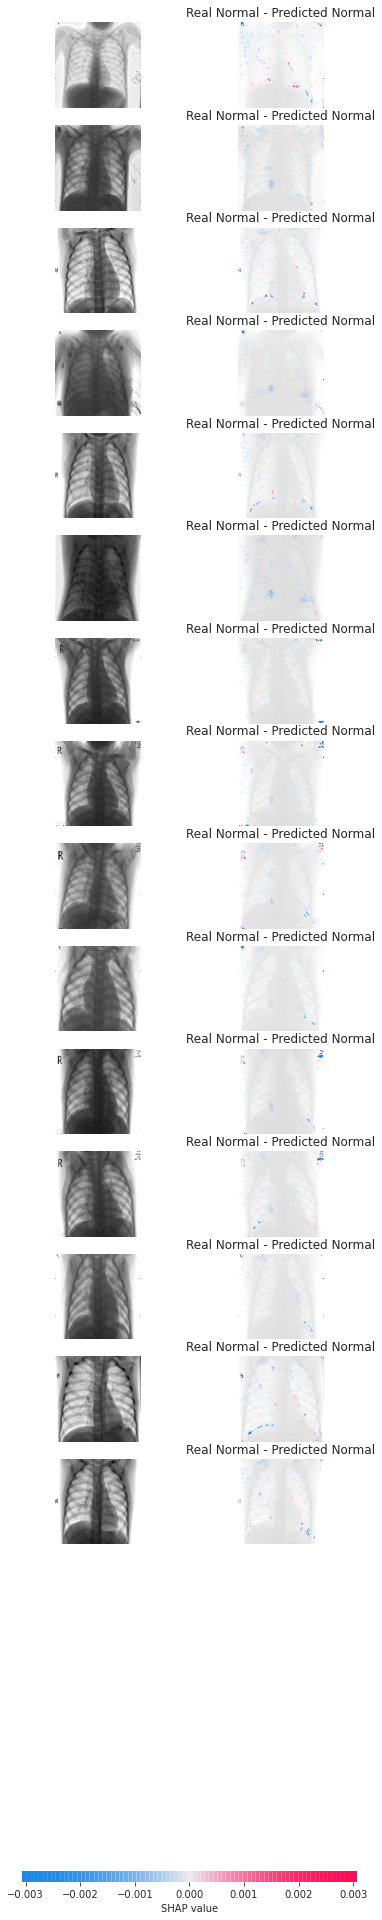

In [70]:
import shap

# Criação do explainer object que será usado pelo modelo
e = shap.DeepExplainer(model, x_test)

# Os valores shap são os valores de explicação
shap_values = e.shap_values(x_test[50:65])

# Plot das imagens explicando as predições
shap.image_plot(shap_values, -x_test[50:65], labels_to_print, show=False)